<a href="https://colab.research.google.com/github/YeongLee-Smart/SUMAN/blob/main/20240915.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#module

In [4]:
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedKFold
import tensorflow as tf
import matplotlib.pyplot as plt
from google.colab import drive
from tensorflow.keras.layers import Dense, Dropout

# Data Load

In [5]:
drive.mount('/content/drive')
file_path = '/content/drive/MyDrive/2024. 8._금융데이터 분석_메타코드/팀 프로젝트 소스/creditcard.csv'
data = pd.read_csv(file_path)

Mounted at /content/drive


# EDA

In [6]:
# data.info() #결측치 없음
data['Class'].value_counts()

,count
Class,
0,284315
1,492


# Train, Test 분리

In [7]:
# 1. X, y 분리
X= data.iloc[:, :-1]
Y= data.iloc[:, -1]
# print(X) # Time~Amount
# print(Y) # Class

# 2. 데이터 정규화 (각 특징에 대해 0~1 사이 값으로 변환)
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X) # X데이터를 scaling
X = pd.DataFrame(X_scaled, index=X.index, columns=X.columns) # X_scaled는 numpy이므로 DataFrame으로 변경

# 3. train, test 분리
from sklearn.model_selection import StratifiedKFold
kfold = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 0)

for train_index, test_index in kfold.split(X, Y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = Y.iloc[train_index], Y.iloc[test_index]

print(X_train.shape, y_train.shape) #(227846, 30) (227846,) 80%
print(X_test.shape, y_test.shape) #(56961, 30) (56961,) 20%

(227846, 30) (227846,)
(56961, 30) (56961,)


# Train, Test 시각화

/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


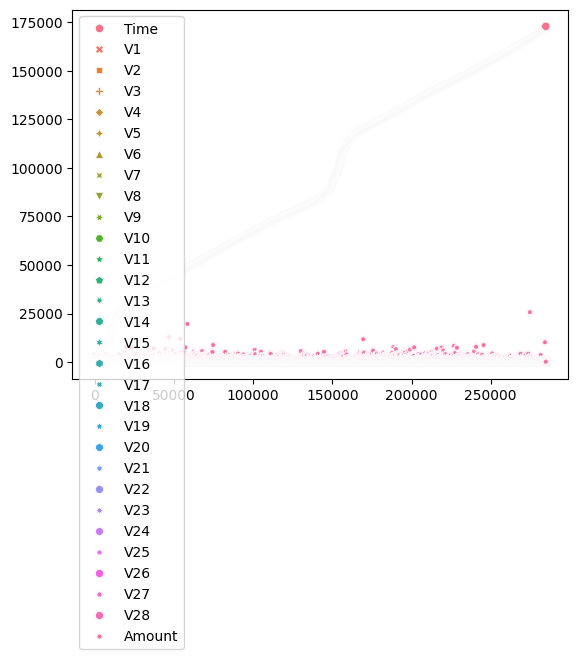

In [ ]:
import seaborn as sns
sns.scatterplot(X_train)
plt.show()

# Hyperparameter

## learning_rate_decay 변경
    exponential -> cosine -> inverse


In [8]:
# 1. 학습률
# 초기값 설정
initial_learning_rate = 0.01
decay_steps = 5
decay_rate = 0.95
epochs = np.arange(1, 101)

# Exponential Decay
exponential_decay = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate, decay_steps=decay_steps, decay_rate=decay_rate
)

# 2. 배치크기
batch_size = 2**12 #13만 #train 데이터의 약 50%크기

## Learning Rate Decay Visualization

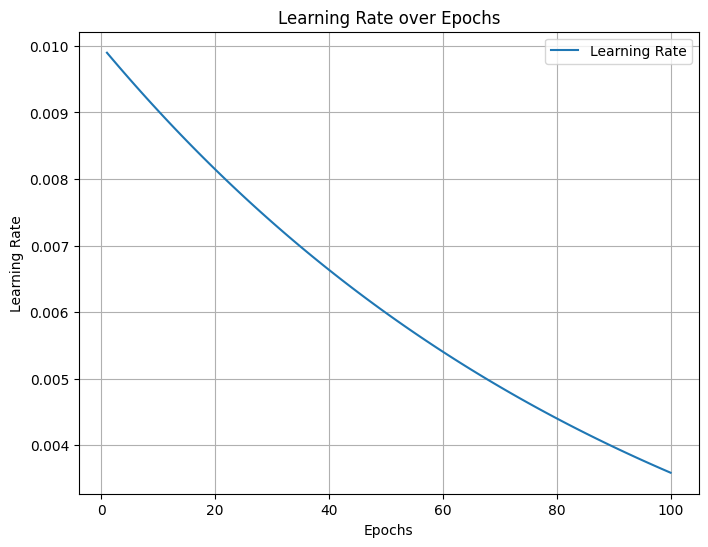

In [9]:
# Exponential Decay 체크
learning_rate_check = []
for epoch in epochs:
    learning_rate = exponential_decay(epoch)
    learning_rate_check.append(learning_rate.numpy())

# 학습율 시각화
plt.figure(figsize=(8, 6))
plt.plot(epochs, learning_rate_check, label='Learning Rate')
plt.xlabel('Epochs')
plt.ylabel('Learning Rate')
plt.title('Learning Rate over Epochs')
plt.legend()
plt.grid(True)
plt.show()

# model 구축

## 가중치 초기화

In [ ]:
print(X_train.shape[1])

30


In [10]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input

model = Sequential()

#가중치 초기화
weight_init = tf.keras.initializers.he_uniform()
# weight_init = tf.keras.initializaers.RandomNormal()
# weight_init = tf.keras.initializaers.glorot_uniform()

#model.add(Input(shape=(X_train.shape[1],)))
model.add(Dense(128, activation='relu', input_dim=30, kernel_initializer=weight_init))  # 첫 번째 은닉층
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))  # 두 번째 은닉층
model.add(Dropout(0.5))  # 50% 드롭아웃 적용
model.add(Dense(32, activation='relu')) # 세 번째 은닉층
model.add(Dense(1, activation='sigmoid'))
model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 128)                 │           3,968 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,337 (56.00 KB)

 Trainable params: 14,337 (56.00 KB)

 Non-trainable params: 0 (0.00 B)

# Optimizer

In [11]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=exponential_decay),
              loss = 'binary_crossentropy',
              metrics = ['accuracy'])

# Training

In [12]:
#생성된 데이터를 batch_size로 나누어, epoch만큼 학습시킴
history = model.fit(X_train, y_train, epochs=len(epochs), validation_data=(X_train, y_train), batch_size = batch_size)

Epoch 1/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 4s 46ms/step - accuracy: 0.9792 - loss: 0.0716 - val_accuracy: 0.9983 - val_loss: 0.0105
Epoch 2/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 48ms/step - accuracy: 0.9983 - loss: 0.0127 - val_accuracy: 0.9983 - val_loss: 0.0079
Epoch 3/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - accuracy: 0.9984 - loss: 0.0094 - val_accuracy: 0.9983 - val_loss: 0.0064
Epoch 4/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - accuracy: 0.9982 - loss: 0.0091 - val_accuracy: 0.9983 - val_loss: 0.0056
Epoch 5/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - accuracy: 0.9984 - loss: 0.0070 - val_accuracy: 0.9983 - val_loss: 0.0054
Epoch 6/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - accuracy: 0.9984 - loss: 0.0072 - val_accuracy: 0.9983 - val_loss: 0.0051
Epoch 7/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - accuracy: 0.9984 - loss: 0.0067 - val_accuracy: 0.9983 - val_loss: 0.0051
Epoch 8/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - accuracy: 0.9982 - loss: 0.0071 - val_accuracy: 0.

## Training Loss and Val_Loss Visualization

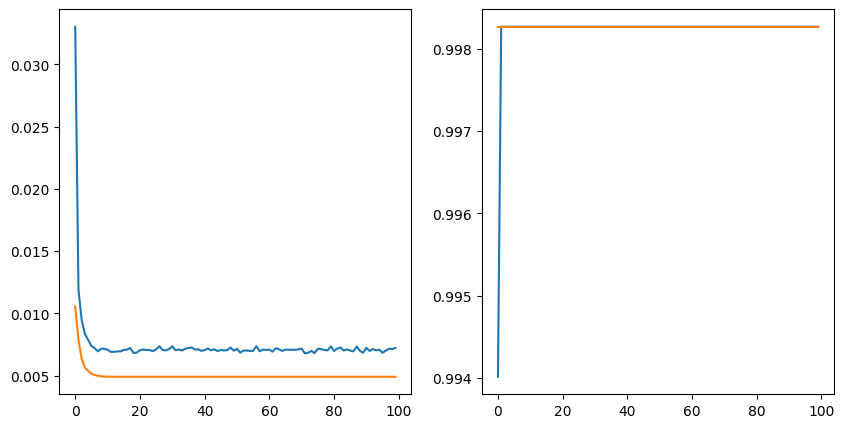

In [18]:
history_df = pd.DataFrame(history.history)
# print(history_df)

plt.figure(figsize=(10, 5))
plt.subplot(121)
plt.plot(history_df.loc[:, ['loss', 'val_loss']])
plt.subplot(122)
plt.plot(history_df.loc[:, ['accuracy', 'val_accuracy']])

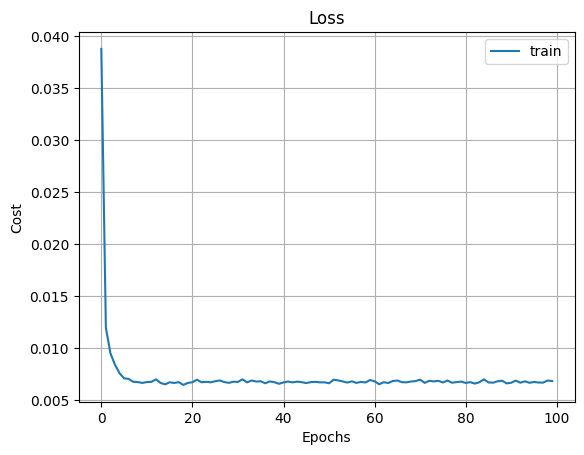

In [85]:
plt.plot(history.history['loss'], label = "train")
plt.xlabel("Epochs")
plt.ylabel("Cost")
plt.title('Loss')
plt.grid()
plt.legend()
plt.show()

# Model Evaluation

In [86]:
eval_loss, eval_acc = model.evaluate(X_test, y_test)
print(f"evaluation_acc = {eval_acc}")
print(f"evaluation_loss = {eval_loss}")

1781/1781 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9979 - loss: 0.0051
evaluation_acc = 0.9982795119285583
evaluation_loss = 0.004773788154125214


# Test

In [19]:
y_pred = model.predict(X_test)

print(y_pred[0])
print(y_test[0])

1781/1781 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step
<class 'numpy.ndarray'>


In [23]:
y_pred_df= pd.DataFrame(y_pred)

y_pred_df.max()????????????????

,0
0,0.415865


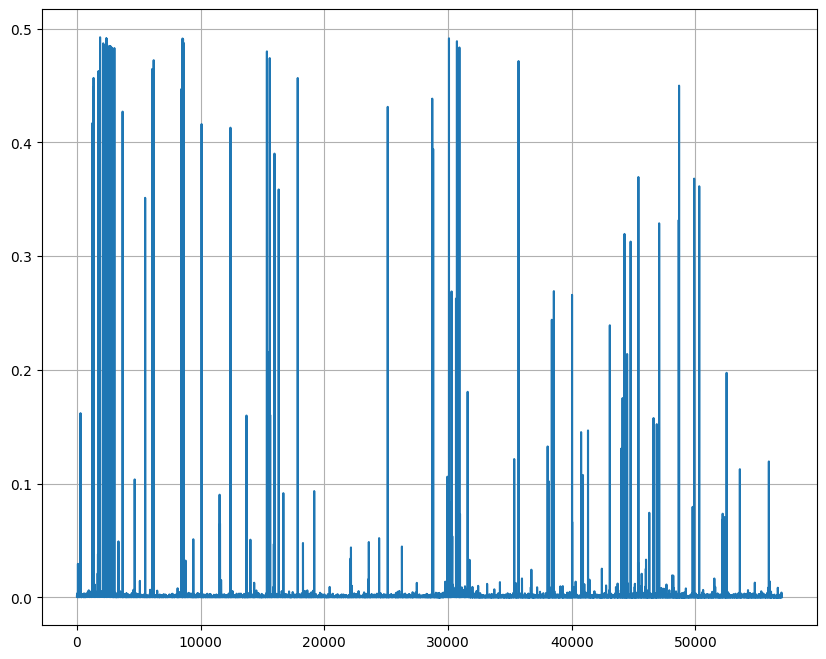

In [89]:
plt.figure(figsize=(10,8))
plt.plot(y_pred) #그래프모양 변경가능
plt.grid()
plt.show()

# accuracy 검증


In [ ]:
# confusion_matrics
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

cnf_matrix = confusion_matrix(y_actual, y_pred, labels = ['cat', 'dog', 'rabbit'])
np.set_printoptions(precision = 2)

plt.figure()
plot_confusion_matrix(cnf_matrix, classes = ['cat', 'dog', 'rabbit'], title = 'confusion matrix without normalization')
plt.show()

# 분류지표 계산
print(classification_report(y_train, y_train_pred))

# ROC(필요하면 쓰기)
from sklearn.metrics import roc_curve, auc
import pandas as pd

y_train_prob = lr.predict_proba(X_train)[:, 1]

fpr, tpr, threshold = roc_curve(y_train, y_train_prob)

a=pd.DataFrame()

a['fpr'] = 1-fpr
a['tpr'] = tpr
a['thres'] = threshold
# p(a)

import matplotlib.pyplot as plt

auc_score = auc(fpr, tpr)

plt.plot(fpr, tpr, label='auc: %.2f'%auc_score)
plt.show()

# Visualization

In [ ]:
plt.figure(figsize=(10,8))
plt.plot(history.history['loss'], label = "train") #그래프모양 변경가능
plt.xlabel("Epochs") # 변수수정
plt.ylabel("Cost") #변수수정
plt.legend()
plt.show()